In [12]:
from xgboost import XGBClassifier 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('./All.csv')
df = df.sample(frac=1)
df.sample(5)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
1620,21,2,9,13.000000,23,2.666667,2,17,9,0,...,9,8,7,0.690780,0.750744,NaN,0.742480,0.751096,0.742274,Defacement
14306,0,3,12,4.333334,8,3.666667,3,21,16,0,...,0,0,-1,0.655547,0.769471,0.711607,0.746181,0.000000,-1.000000,benign
24873,0,3,5,5.666666,11,9.200000,3,10,9,4,...,0,0,-1,0.770395,0.807835,0.910005,0.765564,0.000000,-1.000000,phishing
25087,0,4,8,7.000000,11,3.500000,4,8,8,1,...,1,0,-1,0.725455,0.833899,0.742024,0.916667,0.579380,-1.000000,phishing
13258,20,2,7,6.000000,10,2.500000,2,11,6,0,...,4,0,3,0.739307,0.818007,NaN,0.785982,0.000000,0.790019,benign


## Preprocess
### Content-Based Features
These are obtained from the downloaded HTML code of the webpage. These features capture the structure of the webpage and the content embedded in it. These will include information on script tags, embedded objects, executables, hidden elements, etc.

### Host-Based Features
these are characteristics of the host-name properties of the URL. These provide information about the host of the webpage, for example, country of registration, domain name properties, open ports, named servers, connection speed, time to live from registration, etc.

![image info](https://miro.medium.com/max/1390/1*MNYb5o472rN9bQ4dmLDjTA.png)

In [5]:
print("Types of labels:")
np.unique(df['URL_Type_obf_Type'])

Types of labels:


array(['Defacement', 'benign', 'malware', 'phishing', 'spam'],
      dtype=object)

<BarContainer object of 5 artists>

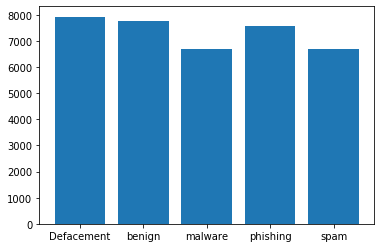

In [5]:
labels,counts = np.unique(df["URL_Type_obf_Type"],return_counts=True)
plt.bar(labels,counts)

In [6]:
df['URL_Type_obf_Type'] = pd.Categorical(df['URL_Type_obf_Type'])
df['URL_Type_obf_Type'] = df['URL_Type_obf_Type'].cat.codes

In [7]:
df.shape

(36707, 80)

### Handling missing data
We drop the features that have more than 20% of its total data missing (null)
and the rest of the features that have some missing data, we drop the rows with null

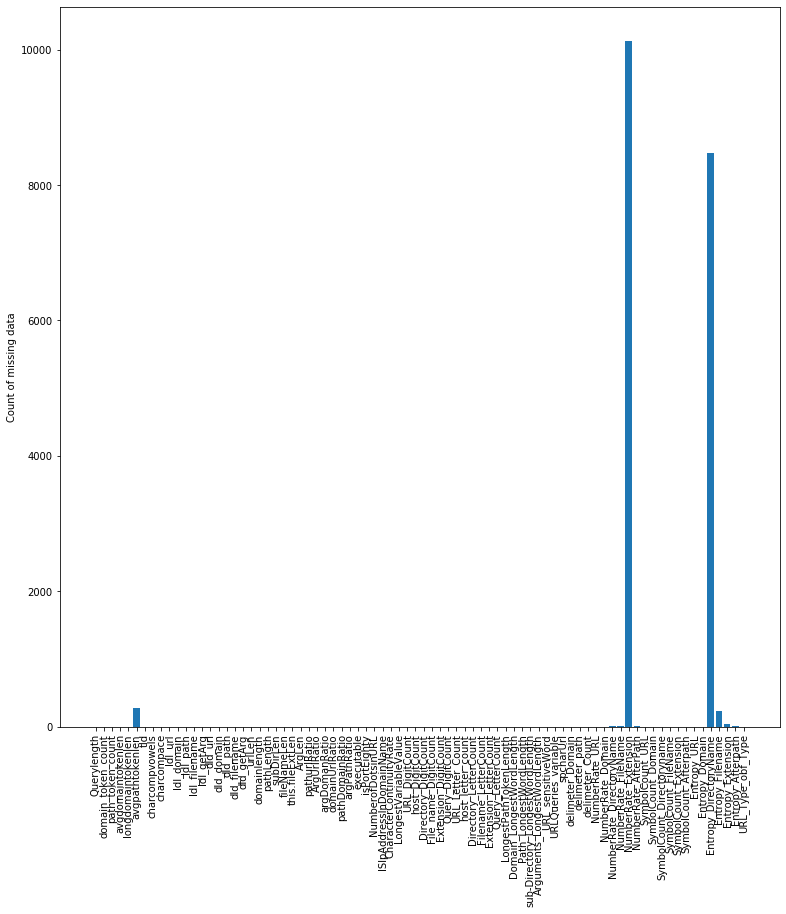

In [9]:
import matplotlib.pyplot as plt

missing_data = df.isnull().sum()
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Count of missing data')
plt.xticks(rotation=90)
ax.bar(df.columns, missing_data)
plt.show()

In [8]:
pct_null = df.isnull().sum() / len(df)
missing_features = pct_null[pct_null > 0.20].index
print(type(missing_features))
print(f"Features with more than 20% missing data are:\n{missing_features}")
df.drop(missing_features, axis=1, inplace=True)
missing_rows = df.isnull().values.ravel().sum()
print(f"\nNumber of rows with missing data: {missing_rows}")
df.dropna(inplace=True)
df.shape

<class 'pandas.core.indexes.base.Index'>
Features with more than 20% missing data are:
Index(['NumberRate_Extension', 'Entropy_DirectoryName'], dtype='object')

Number of rows with missing data: 585


(36133, 78)

In [11]:
corr = df.corr()
corr_label = corr[['URL_Type_obf_Type']]
corr_label.style.background_gradient(cmap='coolwarm')

,URL_Type_obf_Type
Querylength,0.135884
domain_token_count,0.293984
path_token_count,-0.079892
avgdomaintokenlen,-0.121819
longdomaintokenlen,-0.023160
avgpathtokenlen,0.189884
tld,0.293984
charcompvowels,0.029943
charcompace,0.151137
ldl_url,0.249059


### ML Process:

In [30]:
X = df.drop(['URL_Type_obf_Type'], axis=1)
y = df['URL_Type_obf_Type']
X = X.to_numpy()
y = y.to_numpy()
X.shape, y.shape

((36133, 77), (36133,))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [32]:
weights = pd.Series(y_train).value_counts().values / y_train.size
all_weights = np.zeros(y_train.size)
for label in np.unique(y_train):
    all_weights[y_train == label] = weights[label]

In [33]:
xgb = XGBClassifier(n_estimators=5000, learning_rate=0.05, gamma=0, subsample=0.7,
                            objective="multi:softprob",
                            num_class=len(np.unique(y_train)),
                            eval_metric="mlogloss", random_state=93, use_label_encoder=False)


xgb = xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                        early_stopping_rounds=10,
                        sample_weight=all_weights)

[18:06:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.52622	validation_1-mlogloss:1.52622
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.45094	validation_1-mlogloss:1.45074
[2]	validation_0-mlogloss:1.38297	validation_1-mlogloss:1.38359
[3]	validation_0-mlogloss:1.32158	validation_1-mlogloss:1.32226
[4]	validation_0-mlogloss:1.26517	validation_1-mlogloss:1.26551
[5]	validation_0-mlogloss:1.21345	validation_1-mlogloss:1.21364
[6]	validation_0-mlogloss:1.16611	validation_1-mlogloss:1.16585
[7]	validation_0-m

[118]	validation_0-mlogloss:0.14880	validation_1-mlogloss:0.16765
[119]	validation_0-mlogloss:0.14721	validation_1-mlogloss:0.16631
[120]	validation_0-mlogloss:0.14577	validation_1-mlogloss:0.16490
[121]	validation_0-mlogloss:0.14459	validation_1-mlogloss:0.16392
[122]	validation_0-mlogloss:0.14333	validation_1-mlogloss:0.16284
[123]	validation_0-mlogloss:0.14231	validation_1-mlogloss:0.16181
[124]	validation_0-mlogloss:0.14092	validation_1-mlogloss:0.16065
[125]	validation_0-mlogloss:0.13996	validation_1-mlogloss:0.15975
[126]	validation_0-mlogloss:0.13887	validation_1-mlogloss:0.15870
[127]	validation_0-mlogloss:0.13740	validation_1-mlogloss:0.15731
[128]	validation_0-mlogloss:0.13617	validation_1-mlogloss:0.15627
[129]	validation_0-mlogloss:0.13517	validation_1-mlogloss:0.15535
[130]	validation_0-mlogloss:0.13435	validation_1-mlogloss:0.15460
[131]	validation_0-mlogloss:0.13321	validation_1-mlogloss:0.15369
[132]	validation_0-mlogloss:0.13238	validation_1-mlogloss:0.15296
[133]	vali

[243]	validation_0-mlogloss:0.06719	validation_1-mlogloss:0.09829
[244]	validation_0-mlogloss:0.06682	validation_1-mlogloss:0.09811
[245]	validation_0-mlogloss:0.06645	validation_1-mlogloss:0.09775
[246]	validation_0-mlogloss:0.06605	validation_1-mlogloss:0.09747
[247]	validation_0-mlogloss:0.06570	validation_1-mlogloss:0.09713
[248]	validation_0-mlogloss:0.06538	validation_1-mlogloss:0.09692
[249]	validation_0-mlogloss:0.06501	validation_1-mlogloss:0.09657
[250]	validation_0-mlogloss:0.06469	validation_1-mlogloss:0.09624
[251]	validation_0-mlogloss:0.06441	validation_1-mlogloss:0.09607
[252]	validation_0-mlogloss:0.06413	validation_1-mlogloss:0.09583
[253]	validation_0-mlogloss:0.06385	validation_1-mlogloss:0.09564
[254]	validation_0-mlogloss:0.06354	validation_1-mlogloss:0.09540
[255]	validation_0-mlogloss:0.06326	validation_1-mlogloss:0.09516
[256]	validation_0-mlogloss:0.06293	validation_1-mlogloss:0.09494
[257]	validation_0-mlogloss:0.06272	validation_1-mlogloss:0.09483
[258]	vali

[368]	validation_0-mlogloss:0.03872	validation_1-mlogloss:0.07690
[369]	validation_0-mlogloss:0.03857	validation_1-mlogloss:0.07679
[370]	validation_0-mlogloss:0.03845	validation_1-mlogloss:0.07671
[371]	validation_0-mlogloss:0.03827	validation_1-mlogloss:0.07661
[372]	validation_0-mlogloss:0.03809	validation_1-mlogloss:0.07649
[373]	validation_0-mlogloss:0.03796	validation_1-mlogloss:0.07637
[374]	validation_0-mlogloss:0.03781	validation_1-mlogloss:0.07626
[375]	validation_0-mlogloss:0.03767	validation_1-mlogloss:0.07615
[376]	validation_0-mlogloss:0.03752	validation_1-mlogloss:0.07607
[377]	validation_0-mlogloss:0.03738	validation_1-mlogloss:0.07601
[378]	validation_0-mlogloss:0.03727	validation_1-mlogloss:0.07595
[379]	validation_0-mlogloss:0.03714	validation_1-mlogloss:0.07584
[380]	validation_0-mlogloss:0.03698	validation_1-mlogloss:0.07573
[381]	validation_0-mlogloss:0.03682	validation_1-mlogloss:0.07562
[382]	validation_0-mlogloss:0.03667	validation_1-mlogloss:0.07551
[383]	vali

[493]	validation_0-mlogloss:0.02527	validation_1-mlogloss:0.06782
[494]	validation_0-mlogloss:0.02518	validation_1-mlogloss:0.06777
[495]	validation_0-mlogloss:0.02510	validation_1-mlogloss:0.06775
[496]	validation_0-mlogloss:0.02502	validation_1-mlogloss:0.06767
[497]	validation_0-mlogloss:0.02495	validation_1-mlogloss:0.06764
[498]	validation_0-mlogloss:0.02488	validation_1-mlogloss:0.06758
[499]	validation_0-mlogloss:0.02481	validation_1-mlogloss:0.06761
[500]	validation_0-mlogloss:0.02474	validation_1-mlogloss:0.06757
[501]	validation_0-mlogloss:0.02468	validation_1-mlogloss:0.06753
[502]	validation_0-mlogloss:0.02460	validation_1-mlogloss:0.06751
[503]	validation_0-mlogloss:0.02452	validation_1-mlogloss:0.06747
[504]	validation_0-mlogloss:0.02444	validation_1-mlogloss:0.06742
[505]	validation_0-mlogloss:0.02438	validation_1-mlogloss:0.06741
[506]	validation_0-mlogloss:0.02431	validation_1-mlogloss:0.06741
[507]	validation_0-mlogloss:0.02423	validation_1-mlogloss:0.06736
[508]	vali

[618]	validation_0-mlogloss:0.01799	validation_1-mlogloss:0.06378
[619]	validation_0-mlogloss:0.01796	validation_1-mlogloss:0.06376
[620]	validation_0-mlogloss:0.01792	validation_1-mlogloss:0.06372
[621]	validation_0-mlogloss:0.01787	validation_1-mlogloss:0.06371
[622]	validation_0-mlogloss:0.01784	validation_1-mlogloss:0.06369
[623]	validation_0-mlogloss:0.01779	validation_1-mlogloss:0.06366
[624]	validation_0-mlogloss:0.01775	validation_1-mlogloss:0.06369
[625]	validation_0-mlogloss:0.01771	validation_1-mlogloss:0.06367
[626]	validation_0-mlogloss:0.01767	validation_1-mlogloss:0.06358
[627]	validation_0-mlogloss:0.01762	validation_1-mlogloss:0.06353
[628]	validation_0-mlogloss:0.01758	validation_1-mlogloss:0.06350
[629]	validation_0-mlogloss:0.01753	validation_1-mlogloss:0.06344
[630]	validation_0-mlogloss:0.01749	validation_1-mlogloss:0.06340
[631]	validation_0-mlogloss:0.01744	validation_1-mlogloss:0.06338
[632]	validation_0-mlogloss:0.01740	validation_1-mlogloss:0.06337
[633]	vali

[743]	validation_0-mlogloss:0.01364	validation_1-mlogloss:0.06136
[744]	validation_0-mlogloss:0.01362	validation_1-mlogloss:0.06137
[745]	validation_0-mlogloss:0.01359	validation_1-mlogloss:0.06137
[746]	validation_0-mlogloss:0.01356	validation_1-mlogloss:0.06138
[747]	validation_0-mlogloss:0.01354	validation_1-mlogloss:0.06139
[748]	validation_0-mlogloss:0.01351	validation_1-mlogloss:0.06141
[749]	validation_0-mlogloss:0.01349	validation_1-mlogloss:0.06139
[750]	validation_0-mlogloss:0.01346	validation_1-mlogloss:0.06136
[751]	validation_0-mlogloss:0.01344	validation_1-mlogloss:0.06137
[752]	validation_0-mlogloss:0.01340	validation_1-mlogloss:0.06138
[753]	validation_0-mlogloss:0.01337	validation_1-mlogloss:0.06137
[754]	validation_0-mlogloss:0.01335	validation_1-mlogloss:0.06135
[755]	validation_0-mlogloss:0.01333	validation_1-mlogloss:0.06137
[756]	validation_0-mlogloss:0.01330	validation_1-mlogloss:0.06137
[757]	validation_0-mlogloss:0.01327	validation_1-mlogloss:0.06132
[758]	vali

[868]	validation_0-mlogloss:0.01087	validation_1-mlogloss:0.06021
[869]	validation_0-mlogloss:0.01085	validation_1-mlogloss:0.06019
[870]	validation_0-mlogloss:0.01084	validation_1-mlogloss:0.06018
[871]	validation_0-mlogloss:0.01082	validation_1-mlogloss:0.06017
[872]	validation_0-mlogloss:0.01081	validation_1-mlogloss:0.06016
[873]	validation_0-mlogloss:0.01079	validation_1-mlogloss:0.06019
[874]	validation_0-mlogloss:0.01077	validation_1-mlogloss:0.06017
[875]	validation_0-mlogloss:0.01075	validation_1-mlogloss:0.06016
[876]	validation_0-mlogloss:0.01074	validation_1-mlogloss:0.06014
[877]	validation_0-mlogloss:0.01072	validation_1-mlogloss:0.06015
[878]	validation_0-mlogloss:0.01070	validation_1-mlogloss:0.06014
[879]	validation_0-mlogloss:0.01069	validation_1-mlogloss:0.06017
[880]	validation_0-mlogloss:0.01068	validation_1-mlogloss:0.06017
[881]	validation_0-mlogloss:0.01066	validation_1-mlogloss:0.06016
[882]	validation_0-mlogloss:0.01064	validation_1-mlogloss:0.06016
[883]	vali

In [34]:
# predict classification report
y_pred = xgb.predict(X_test)
# print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1579
           1       0.99      0.99      0.99      1480
           2       0.98      0.98      0.98      1315
           3       0.97      0.97      0.97      1454
           4       0.99      0.99      0.99      1399

    accuracy                           0.98      7227
   macro avg       0.98      0.98      0.98      7227
weighted avg       0.98      0.98      0.98      7227



In [35]:
predictions = [round(value) for value in y_pred]
xgb_accuracy = accuracy_score(y_test, predictions)
print("XGBoost Accuracy: %.2f%%" % (xgb_accuracy * 100.0))

XGBoost Accuracy: 98.37%


In [11]:
import pickle
with open("xgb_good", "wb") as file:
    pickle.dump(xgb, file)

In [47]:
df_binary = df.copy()
df_binary['label'] = df_binary['URL_Type_obf_Type'].map({'benign':0, 'malware':1,'Defacement':1, 'spam':1, 'phishing':1})
df_binary.drop(['URL_Type_obf_Type'], axis=1, inplace=True)

1    28926
0     7781
Name: label, dtype: int64


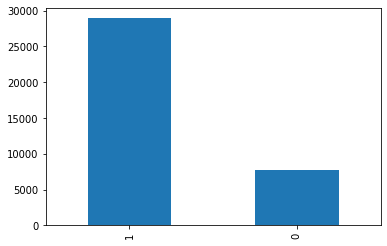

In [54]:
print(df_binary['label'].value_counts())
df_binary['label'].value_counts().plot(kind='bar')

In [40]:
X_binary = df_binary.drop(['label'], axis=1)
y_binary = df_binary['label']
X_binary = X_binary.to_numpy()
y_binary = y_binary.to_numpy()
X_binary.shape, y_binary.shape

((36707, 79), (36707,))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [44]:
xgb = XGBClassifier(n_estimators=5000, learning_rate=0.05, gamma=0, subsample=0.7,
                            objective="multi:softprob",
                            num_class=len(np.unique(y_train)),
                            eval_metric="mlogloss", random_state=93, use_label_encoder=False)


xgb = xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],
                        early_stopping_rounds=10,
                        sample_weight=all_weights)

[17:31:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:0.65303	validation_1-mlogloss:0.65307
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.61700	validation_1-mlogloss:0.61708
[2]	validation_0-mlogloss:0.58413	validation_1-mlogloss:0.58419
[3]	validation_0-mlogloss:0.55422	validation_1-mlogloss:0.55432
[4]	validation_0-mlogloss:0.52700	validation_1-mlogloss:0.52708
[5]	validation_0-mlogloss:0.50184	validation_1-mlogloss:0.50186
[6]	validation_0-mlogloss:0.47879	validation_1-mlogloss:0.47878
[7]	validation_0-m

[118]	validation_0-mlogloss:0.04787	validation_1-mlogloss:0.05499
[119]	validation_0-mlogloss:0.04750	validation_1-mlogloss:0.05468
[120]	validation_0-mlogloss:0.04718	validation_1-mlogloss:0.05436
[121]	validation_0-mlogloss:0.04694	validation_1-mlogloss:0.05410
[122]	validation_0-mlogloss:0.04642	validation_1-mlogloss:0.05364
[123]	validation_0-mlogloss:0.04598	validation_1-mlogloss:0.05330
[124]	validation_0-mlogloss:0.04553	validation_1-mlogloss:0.05291
[125]	validation_0-mlogloss:0.04526	validation_1-mlogloss:0.05266
[126]	validation_0-mlogloss:0.04486	validation_1-mlogloss:0.05225
[127]	validation_0-mlogloss:0.04461	validation_1-mlogloss:0.05205
[128]	validation_0-mlogloss:0.04437	validation_1-mlogloss:0.05184
[129]	validation_0-mlogloss:0.04391	validation_1-mlogloss:0.05142
[130]	validation_0-mlogloss:0.04335	validation_1-mlogloss:0.05099
[131]	validation_0-mlogloss:0.04308	validation_1-mlogloss:0.05078
[132]	validation_0-mlogloss:0.04265	validation_1-mlogloss:0.05048
[133]	vali

[243]	validation_0-mlogloss:0.01938	validation_1-mlogloss:0.03207
[244]	validation_0-mlogloss:0.01921	validation_1-mlogloss:0.03192
[245]	validation_0-mlogloss:0.01910	validation_1-mlogloss:0.03181
[246]	validation_0-mlogloss:0.01897	validation_1-mlogloss:0.03171
[247]	validation_0-mlogloss:0.01886	validation_1-mlogloss:0.03162
[248]	validation_0-mlogloss:0.01874	validation_1-mlogloss:0.03158
[249]	validation_0-mlogloss:0.01860	validation_1-mlogloss:0.03152
[250]	validation_0-mlogloss:0.01847	validation_1-mlogloss:0.03140
[251]	validation_0-mlogloss:0.01837	validation_1-mlogloss:0.03133
[252]	validation_0-mlogloss:0.01832	validation_1-mlogloss:0.03130
[253]	validation_0-mlogloss:0.01822	validation_1-mlogloss:0.03123
[254]	validation_0-mlogloss:0.01808	validation_1-mlogloss:0.03113
[255]	validation_0-mlogloss:0.01795	validation_1-mlogloss:0.03104
[256]	validation_0-mlogloss:0.01778	validation_1-mlogloss:0.03091
[257]	validation_0-mlogloss:0.01765	validation_1-mlogloss:0.03078
[258]	vali

[368]	validation_0-mlogloss:0.00929	validation_1-mlogloss:0.02397
[369]	validation_0-mlogloss:0.00925	validation_1-mlogloss:0.02394
[370]	validation_0-mlogloss:0.00920	validation_1-mlogloss:0.02391
[371]	validation_0-mlogloss:0.00917	validation_1-mlogloss:0.02387
[372]	validation_0-mlogloss:0.00911	validation_1-mlogloss:0.02384
[373]	validation_0-mlogloss:0.00909	validation_1-mlogloss:0.02382
[374]	validation_0-mlogloss:0.00904	validation_1-mlogloss:0.02376
[375]	validation_0-mlogloss:0.00899	validation_1-mlogloss:0.02373
[376]	validation_0-mlogloss:0.00895	validation_1-mlogloss:0.02371
[377]	validation_0-mlogloss:0.00892	validation_1-mlogloss:0.02372
[378]	validation_0-mlogloss:0.00887	validation_1-mlogloss:0.02367
[379]	validation_0-mlogloss:0.00884	validation_1-mlogloss:0.02364
[380]	validation_0-mlogloss:0.00878	validation_1-mlogloss:0.02359
[381]	validation_0-mlogloss:0.00872	validation_1-mlogloss:0.02351
[382]	validation_0-mlogloss:0.00869	validation_1-mlogloss:0.02346
[383]	vali

[493]	validation_0-mlogloss:0.00537	validation_1-mlogloss:0.02075
[494]	validation_0-mlogloss:0.00535	validation_1-mlogloss:0.02073
[495]	validation_0-mlogloss:0.00533	validation_1-mlogloss:0.02072
[496]	validation_0-mlogloss:0.00530	validation_1-mlogloss:0.02069
[497]	validation_0-mlogloss:0.00527	validation_1-mlogloss:0.02066
[498]	validation_0-mlogloss:0.00525	validation_1-mlogloss:0.02064
[499]	validation_0-mlogloss:0.00523	validation_1-mlogloss:0.02062
[500]	validation_0-mlogloss:0.00521	validation_1-mlogloss:0.02056
[501]	validation_0-mlogloss:0.00519	validation_1-mlogloss:0.02054
[502]	validation_0-mlogloss:0.00516	validation_1-mlogloss:0.02053
[503]	validation_0-mlogloss:0.00515	validation_1-mlogloss:0.02048
[504]	validation_0-mlogloss:0.00513	validation_1-mlogloss:0.02049
[505]	validation_0-mlogloss:0.00511	validation_1-mlogloss:0.02048
[506]	validation_0-mlogloss:0.00508	validation_1-mlogloss:0.02048
[507]	validation_0-mlogloss:0.00506	validation_1-mlogloss:0.02048
[508]	vali

[618]	validation_0-mlogloss:0.00350	validation_1-mlogloss:0.01932
[619]	validation_0-mlogloss:0.00349	validation_1-mlogloss:0.01932
[620]	validation_0-mlogloss:0.00348	validation_1-mlogloss:0.01932
[621]	validation_0-mlogloss:0.00347	validation_1-mlogloss:0.01929
[622]	validation_0-mlogloss:0.00346	validation_1-mlogloss:0.01925
[623]	validation_0-mlogloss:0.00345	validation_1-mlogloss:0.01923
[624]	validation_0-mlogloss:0.00344	validation_1-mlogloss:0.01923
[625]	validation_0-mlogloss:0.00343	validation_1-mlogloss:0.01921
[626]	validation_0-mlogloss:0.00343	validation_1-mlogloss:0.01920
[627]	validation_0-mlogloss:0.00341	validation_1-mlogloss:0.01919
[628]	validation_0-mlogloss:0.00341	validation_1-mlogloss:0.01919
[629]	validation_0-mlogloss:0.00340	validation_1-mlogloss:0.01920
[630]	validation_0-mlogloss:0.00339	validation_1-mlogloss:0.01919
[631]	validation_0-mlogloss:0.00338	validation_1-mlogloss:0.01918
[632]	validation_0-mlogloss:0.00337	validation_1-mlogloss:0.01918
[633]	vali

In [45]:
# predict classification report
y_pred_binary = xgb.predict(X_test)
# print classification report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1567
           1       1.00      1.00      1.00      5775

    accuracy                           0.99      7342
   macro avg       0.99      0.99      0.99      7342
weighted avg       0.99      0.99      0.99      7342



In [ ]:
# strategy = tf.distribute.MirroredStrategy()
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Flatten
model = Sequential()
model.add(Dense(60, activation="relu",input_shape=(77,)))
model.add(Dropout(0.3))
model.add(Dense(30, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
y = np_utils.to_categorical(encoded_Y)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(X_train,y_train,batch_size=200,epochs=2500,
                    validation_split=0.05,
                    use_multiprocessing=True,workers=8,callbacks=[callback])

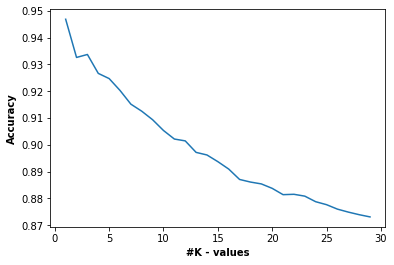

In [13]:
from sklearn.neighbors import KNeighborsClassifier


score_list=[]
for i in range(1,30):
    knnPlot = KNeighborsClassifier(n_neighbors=i)
    knnPlot.fit(X_train,y_train)
    score_list.append(knnPlot.score(X_test,y_test))

plt.plot(range(1,30),score_list)
plt.xlabel('#K - values', fontweight="bold")
plt.ylabel('Accuracy', fontweight="bold")
plt.show()

In [23]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics

max_neighbor = np.argmax(score_list)+1
knn = KNeighborsClassifier(n_neighbors = max_neighbor)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
knn_accuracy = metrics.accuracy_score(y_test, y_pred_knn)
knn_cm = metrics.confusion_matrix(y_test, y_pred_knn)
print("-----------------K-nearest neighbors Report---------------")
print("F1 score: {}".format(knn_f1))
print("Accuracy score: {}".format(knn_accuracy))
print("Confusion matrix: \n", knn_cm)
print(metrics.classification_report(y_test, y_pred_knn))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(knn,X_test, y_test, cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")
knn_mean_score = cv_scores.mean()

-----------------K-nearest neighbors Report---------------
F1 score: 0.9465764869493076
Accuracy score: 0.9468659194686592
Confusion matrix: 
 [[1527    8    6   31    7]
 [  12 1402   29   24   13]
 [   7    4 1290   12    2]
 [  53   43   33 1283   42]
 [  16    9    3   30 1341]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1579
           1       0.96      0.95      0.95      1480
           2       0.95      0.98      0.96      1315
           3       0.93      0.88      0.91      1454
           4       0.95      0.96      0.96      1399

    accuracy                           0.95      7227
   macro avg       0.95      0.95      0.95      7227
weighted avg       0.95      0.95      0.95      7227

Cross Validation Scores: [0.90387275 0.90525588 0.89342561 0.90034602 0.89411765]
Cross Validation Scores Mean: 0.8994035808123592 



In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0,n_jobs=-1)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
rf_f1 = metrics.f1_score(y_test, y_pred_rf, average= "weighted")
rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
rf_cm = metrics.confusion_matrix(y_test, y_pred_rf)
print("--------------------Random Forest------------------")
print("F1 score: {}".format(rf_f1))
print("Accuracy score: {}".format(rf_accuracy))
print("Confusion matrix: \n", rf_cm)
print(metrics.classification_report(y_test, y_pred_rf))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(rf, X_test, y_test, cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")
rf_mean_score = cv_scores.mean()

--------------------Random Forest------------------
F1 score: 0.9697773780408786
Accuracy score: 0.9696969696969697
Confusion matrix: 
 [[1535    4    2   34    4]
 [   2 1453    4   19    2]
 [   4    5 1286   19    1]
 [  21   33   10 1381    9]
 [  11    1    3   31 1353]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1579
           1       0.97      0.98      0.98      1480
           2       0.99      0.98      0.98      1315
           3       0.93      0.95      0.94      1454
           4       0.99      0.97      0.98      1399

    accuracy                           0.97      7227
   macro avg       0.97      0.97      0.97      7227
weighted avg       0.97      0.97      0.97      7227

Cross Validation Scores: [0.93153527 0.93775934 0.94048443 0.93356401 0.93079585]
Cross Validation Scores Mean: 0.9348277792933135 



In [26]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression()
lgr.fit(X_train,y_train)
y_pred_lgr = lgr.predict(X_test)
lgr_f1 = metrics.f1_score(y_test, y_pred_lgr, average= "weighted")
lgr_accuracy = metrics.accuracy_score(y_test, y_pred_lgr)
lgr_cm = metrics.confusion_matrix(y_test, y_pred_lgr)
print("--------------------Logistic Regression------------------")
print("F1 score: {}".format(lgr_f1))
print("Accuracy score: {}".format(lgr_accuracy))
print("Confusion matrix: \n", lgr_cm)
print(metrics.classification_report(y_test, y_pred_lgr))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(lgr, X_test, y_test, cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")
lgr_mean_score = cv_scores.mean()

--------------------Logistic Regression------------------
F1 score: 0.8234684322773951
Accuracy score: 0.8257921682579217
Confusion matrix: 
 [[1337   48   48  104   42]
 [  28 1301   87   51   13]
 [ 110  228  825  132   20]
 [  42   45   69 1254   44]
 [  78    4   22   44 1251]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1579
           1       0.80      0.88      0.84      1480
           2       0.78      0.63      0.70      1315
           3       0.79      0.86      0.83      1454
           4       0.91      0.89      0.90      1399

    accuracy                           0.83      7227
   macro avg       0.83      0.82      0.82      7227
weighted avg       0.83      0.83      0.82      7227

Cross Validation Scores: [0.81396957 0.81396957 0.82768166 0.81522491 0.81384083]
Cross Validation Scores Mean: 0.816937309461251 



In [29]:
from sklearn.tree import DecisionTreeClassifier

decsion_tree_model = DecisionTreeClassifier(random_state=42)
decsion_tree_model.fit(X_train, y_train)
y_pred_dt = decsion_tree_model.predict(X_test)
dt_f1 = metrics.f1_score(y_test, y_pred_dt, average= "weighted")
dt_accuracy = metrics.accuracy_score(y_test, y_pred_dt)
dt_cm = metrics.confusion_matrix(y_test, y_pred_dt)
print("--------------------Decision Tree------------------")
print("F1 score: {}".format(dt_f1))
print("Accuracy score: {}".format(dt_accuracy))
print("Confusion matrix: \n", dt_cm)
print(metrics.classification_report(y_test, y_pred_dt))
kf = KFold(n_splits=5,shuffle=True, random_state=123)
cv_scores = cross_val_score(decsion_tree_model, X_test, y_test, cv=kf)
print("Cross Validation Scores:", cv_scores)
print("Cross Validation Scores Mean:", cv_scores.mean(),"\n")
dt_mean_score = cv_scores.mean()

--------------------Decision Tree------------------
F1 score: 0.9514458054185977
Accuracy score: 0.9517088695170887
Confusion matrix: 
 [[1523    6    7   33   10]
 [   7 1436   13   23    1]
 [   2    6 1286   18    3]
 [  49   29   57 1283   36]
 [  10    5    5   29 1350]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1579
           1       0.97      0.97      0.97      1480
           2       0.94      0.98      0.96      1315
           3       0.93      0.88      0.90      1454
           4       0.96      0.96      0.96      1399

    accuracy                           0.95      7227
   macro avg       0.95      0.95      0.95      7227
weighted avg       0.95      0.95      0.95      7227

Cross Validation Scores: [0.91009682 0.90318119 0.89757785 0.90380623 0.91141869]
Cross Validation Scores Mean: 0.905216155292969 



In [28]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1)
clf.fit(X_train, y_train)
clf.predict(X_test)
clf.loss_
mlp_score = clf.score(X_test, y_test)
mlp_score

0.9312301093123011

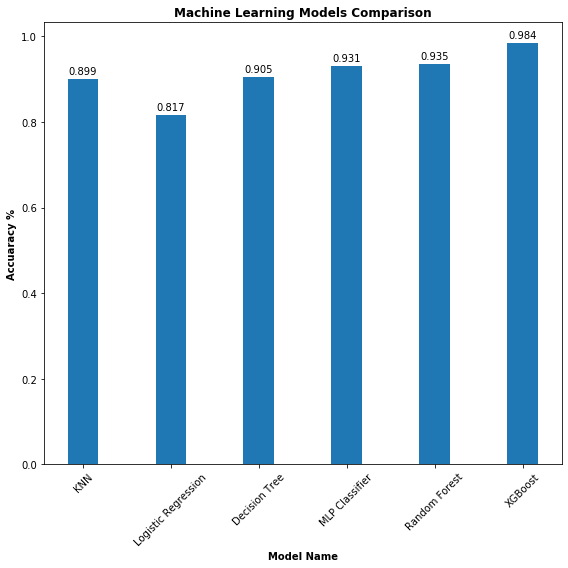

In [62]:
labels = ['KNN', 'Logistic Regression', 'Decision Tree', 'MLP Classifier', 'Random Forest', 'XGBoost']
all_model_scores = [knn_mean_score, lgr_mean_score, dt_mean_score, mlp_score, rf_mean_score, xgb_accuracy]

x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(8,8))
models = ax.bar(x, all_model_scores, width)
ax.set_title('Machine Learning Models Comparison', fontweight="bold")
ax.set_xlabel('Model Name', fontweight="bold")
ax.set_ylabel('Accuaracy %', fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(models)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd
df = pd.read_csv('./All.csv')
df = df.sample(frac=1)


In [ ]:
import matplotlib.pyplot as plt
labels,counts = np.unique(df["URL_Type_obf_Type"],return_counts=True)
plt.bar(labels,counts)

In [ ]:
nans[(nans < 1000) & (nans > 0)]

In [ ]:
nans = df.isna().sum()
df = df.drop(list(nans[nans > 5000].index),axis=1)
df = df.dropna()
df

In [ ]:
df['URL_Type_obf_Type'] = pd.Categorical(df['URL_Type_obf_Type'])
df['URL_Type_obf_Type'] = df['URL_Type_obf_Type'].cat.codes
X = df.drop(['URL_Type_obf_Type'], axis=1)
y = df['URL_Type_obf_Type']
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
weights = pd.Series(y_train).value_counts().values / y_train.size
all_weights = np.zeros(y_train.size)
for label in np.unique(y_train):
    all_weights[y_train == label] = weights[label]

In [ ]:
# strategy = tf.distribute.MirroredStrategy()
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Flatten
model = Sequential()
model.add(Dense(60, activation="relu",input_shape=(77,)))
model.add(Dropout(0.3))
model.add(Dense(30, activation="relu"))
model.add(Dense(15, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=["accuracy",tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
y = np_utils.to_categorical(LabelEncoder().fit_transform(y_train))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(X_train,y_train,batch_size=200,epochs=2500,
                    validation_split=0.05,
                    use_multiprocessing=True,workers=8,callbacks=[callback])

In [ ]:
model.save("mlp_model")

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1)))